<a href="https://colab.research.google.com/github/sandesarikeerthi/2303a51635-batch-23/blob/main/projectcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Dtypes after cleaning:
Name                     object
Location                 object
Rank                      Int64
Description              object
Tuition and fees        float64
In-state                float64
Undergrad Enrollment      Int64
dtype: object

Missing values by column:
Name                    0
Location                0
Rank                    0
Description             0
Tuition and fees        0
In-state                0
Undergrad Enrollment    0
dtype: int64

Saved cleaned CSV to: /content/universities_cleaned.csv

Summary statistics (numeric):
             Rank  Tuition and fees      In-state  Undergrad Enrollment
count       231.0        231.000000    231.000000                 231.0
mean   113.982684      33769.246753  24270.796537          14946.619048
std     65.995518      10756.733516  16806.080721          10569.664095
min           1.0       5300.000000   4965.000000                1001.0
25%          56.0      25693.000000  10111.500000                623

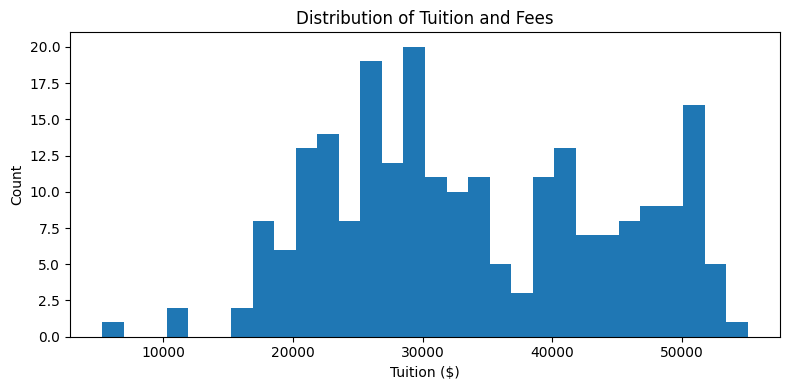

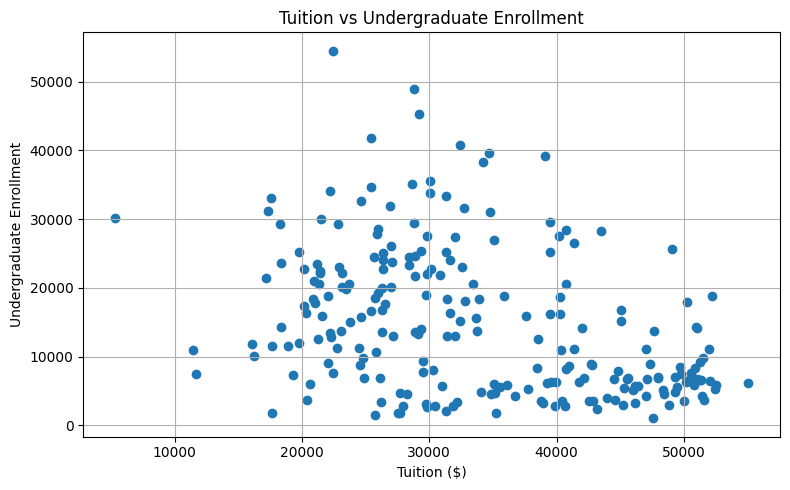

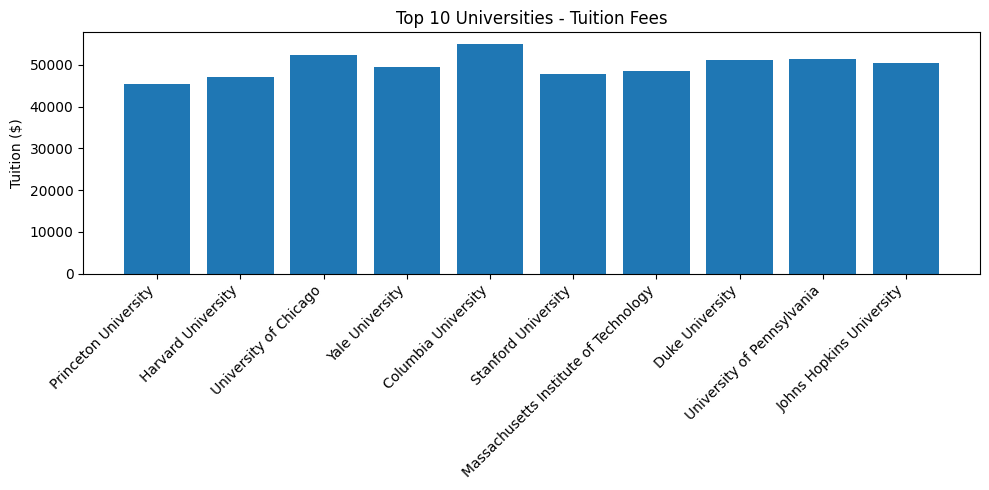


Correlation matrix:
                           Rank  Tuition and fees  Undergrad Enrollment  \
Rank                  1.000000         -0.715094             -0.040771   
Tuition and fees     -0.715094          1.000000             -0.386056   
Undergrad Enrollment -0.040771         -0.386056              1.000000   
In-state             -0.510462          0.871682             -0.606123   

                      In-state  
Rank                 -0.510462  
Tuition and fees      0.871682  
Undergrad Enrollment -0.606123  
In-state              1.000000  


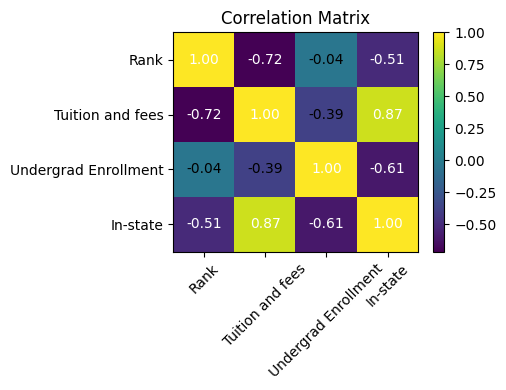


Rows used for ML: 231

Linear Regression results:
 - MAE: 28.775
 - R^2: 0.645
 - Coefficients:
    Tuition and fees: -0.006119
    Undergrad Enrollment: -0.002173
    In-state: 0.000734
 - Intercept: 335.242913


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def clean_currency(series):
    # Remove non-numeric characters except dot, then convert to float (NaN on failure)
    return pd.to_numeric(series.astype(str).str.replace(r'[^0-9.]', '', regex=True), errors='coerce')

def clean_integer(series):
    # Remove non-digit characters then convert to integer (NaN on failure)
    return pd.to_numeric(series.astype(str).str.replace(r'[^0-9]', '', regex=True), errors='coerce').astype('Int64')

INPATH = "/content/universities_cleaned.csv"
CLEANED_CSV = "/content/universities_cleaned.csv"

# Load
df = pd.read_csv(INPATH)

# Remove accidental index columns (if present)
for possible_index in ["index", "Index", "Unnamed: 0"]:
    if possible_index in df.columns:
        df = df.drop(columns=[possible_index])

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Clean numeric columns
df['Tuition and fees'] = clean_currency(df['Tuition and fees']).astype(float)
df['In-state'] = clean_currency(df['In-state']).astype(float) if 'In-state' in df.columns else np.nan
# If In-state missing, use Tuition as fallback
df['In-state'] = df['In-state'].fillna(df['Tuition and fees'])
df['Undergrad Enrollment'] = clean_integer(df['Undergrad Enrollment']).astype('Int64')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce').astype('Int64')

# Quick checks
print("\nDtypes after cleaning:")
print(df.dtypes)
print("\nMissing values by column:")
print(df.isnull().sum())

# Save cleaned CSV
df.to_csv(CLEANED_CSV, index=False)
print(f"\nSaved cleaned CSV to: {CLEANED_CSV}")

# EDA: summary and top 10
print("\nSummary statistics (numeric):")
print(df.describe())

top10 = df.dropna(subset=["Rank"]).sort_values("Rank").head(10)
print("\nTop 10 Universities:")
print(top10[["Rank","Name","Location","Tuition and fees","Undergrad Enrollment"]].to_string(index=False))

# Plots (matplotlib)
plt.figure(figsize=(8,4))
plt.hist(df['Tuition and fees'].dropna(), bins=30)
plt.title('Distribution of Tuition and Fees')
plt.xlabel('Tuition ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df['Tuition and fees'], df['Undergrad Enrollment'])
plt.title('Tuition vs Undergraduate Enrollment')
plt.xlabel('Tuition ($)')
plt.ylabel('Undergraduate Enrollment')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
names = top10['Name'].astype(str).tolist()
tuition_vals = top10['Tuition and fees'].tolist()
plt.bar(names, tuition_vals)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Universities - Tuition Fees')
plt.ylabel('Tuition ($)')
plt.tight_layout()
plt.show()

# Correlation
corr_cols = [col for col in ["Rank","Tuition and fees","Undergrad Enrollment","In-state"] if col in df.columns]
corr = df[corr_cols].corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(5,4))
plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
plt.yticks(range(len(corr_cols)), corr_cols)
for (i, j), val in np.ndenumerate(corr.values):
    plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.4 else 'black')
plt.colorbar()
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Simple ML: predict Rank using tuition/enrollment
ml_df = df[['Tuition and fees', 'Undergrad Enrollment', 'In-state', 'Rank']].dropna()
print(f"\nRows used for ML: {ml_df.shape[0]}")
if ml_df.shape[0] >= 10:
    X = ml_df[['Tuition and fees', 'Undergrad Enrollment', 'In-state']].astype(float)
    y = ml_df['Rank'].astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("\nLinear Regression results:")
    print(f" - MAE: {mae:.3f}")
    print(f" - R^2: {r2:.3f}")
    print(" - Coefficients:")
    for name, coef in zip(X.columns, model.coef_):
        print(f"    {name}: {coef:.6f}")
    print(f" - Intercept: {model.intercept_:.6f}")
else:
    print("\nNot enough rows to train ML model after cleaning.")


Name                     object
Location                 object
Rank                      Int64
Description              object
Tuition and fees        float64
In-state                float64
Undergrad Enrollment      Int64
dtype: object
Name                    0
Location                0
Rank                    0
Description             0
Tuition and fees        0
In-state                0
Undergrad Enrollment    0
dtype: int64
             Rank  Tuition and fees      In-state  Undergrad Enrollment
count       231.0        231.000000    231.000000                 231.0
mean   113.982684      33769.246753  24270.796537          14946.619048
std     65.995518      10756.733516  16806.080721          10569.664095
min           1.0       5300.000000   4965.000000                1001.0
25%          56.0      25693.000000  10111.500000                6238.5
50%         111.0      31608.000000  14070.000000               12949.0
75%         171.0      42721.000000  42348.000000              

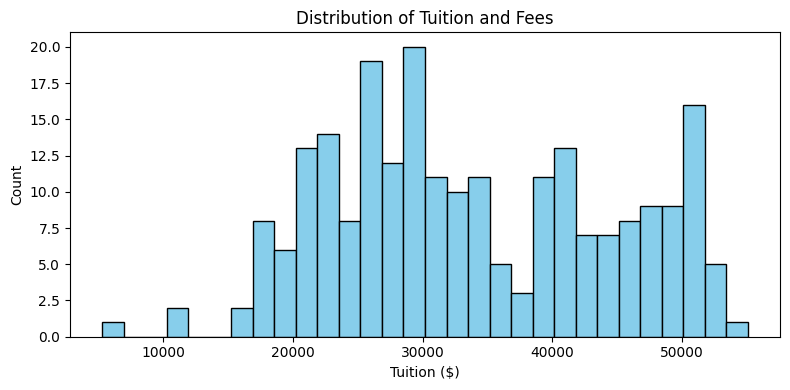

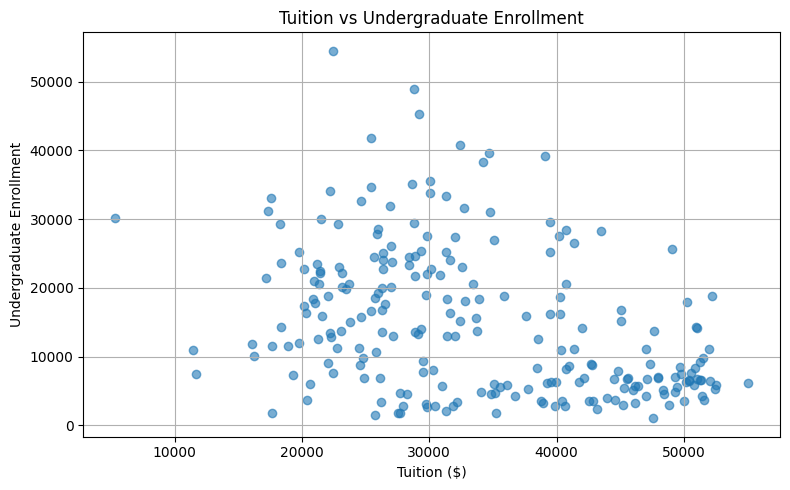

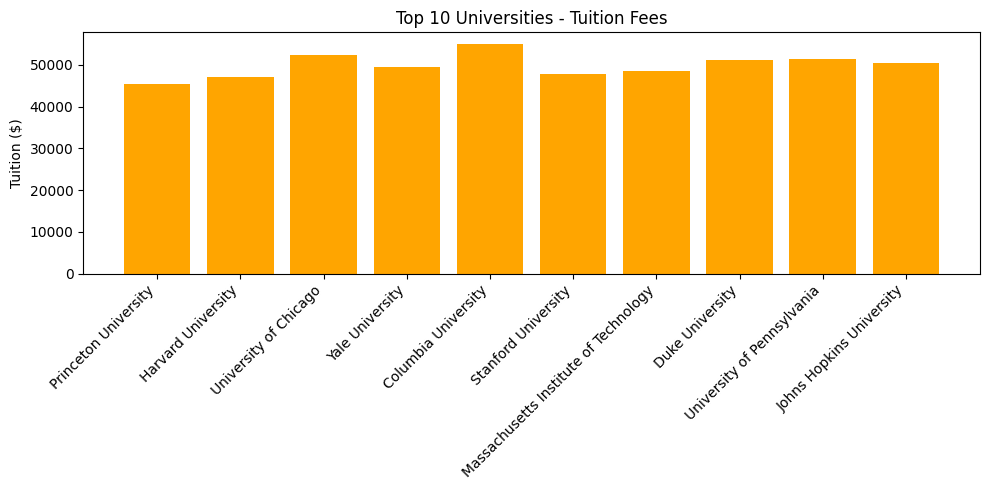

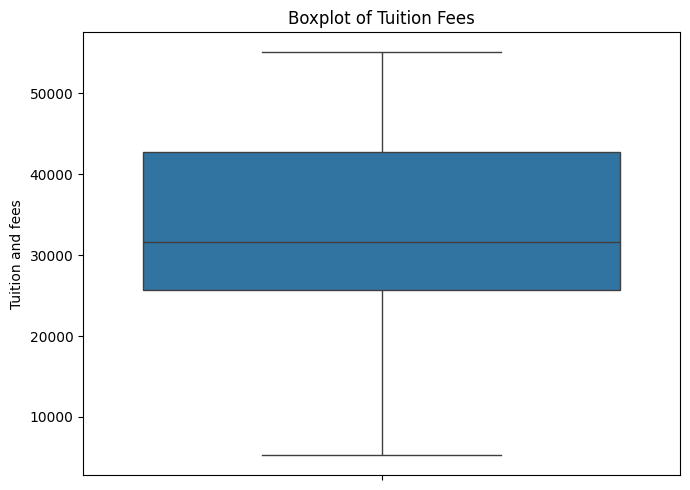

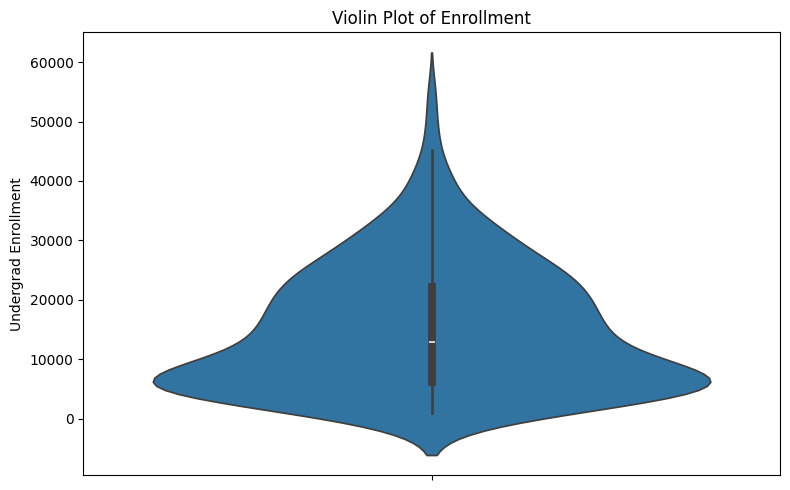

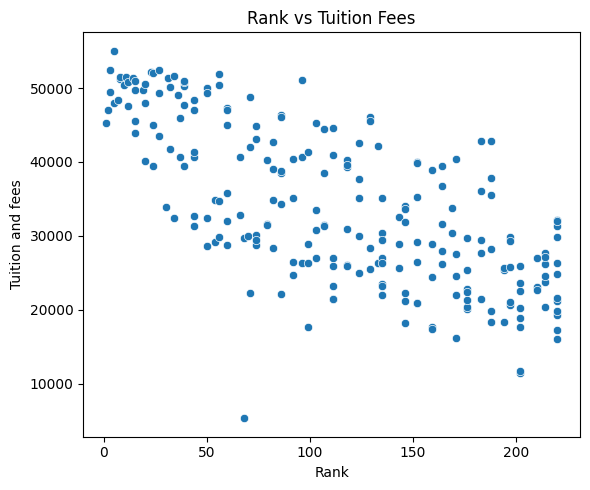

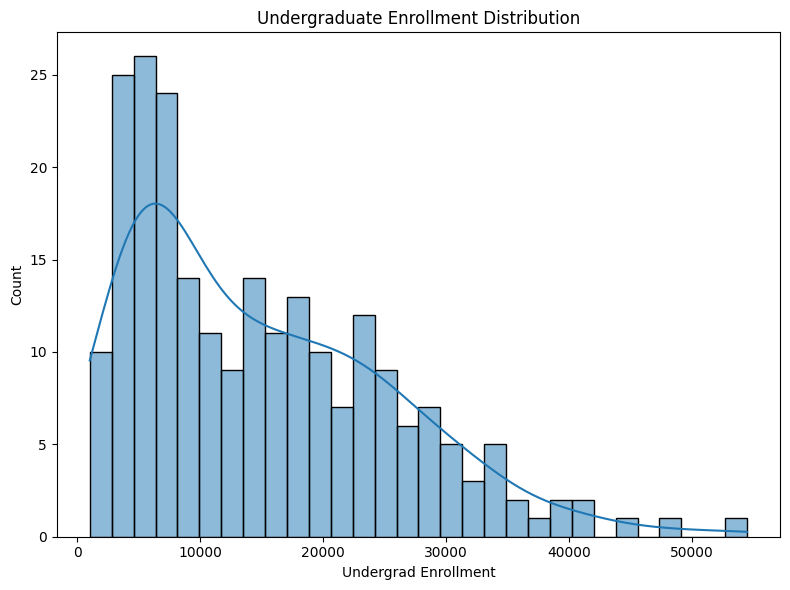

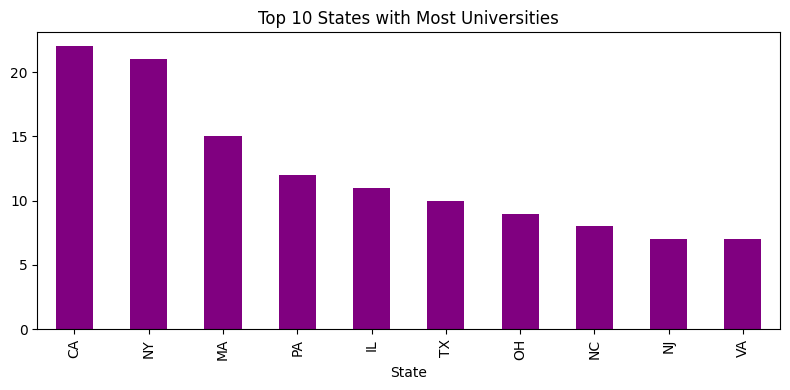

                          Rank  Tuition and fees  Undergrad Enrollment  \
Rank                  1.000000         -0.715094             -0.040771   
Tuition and fees     -0.715094          1.000000             -0.386056   
Undergrad Enrollment -0.040771         -0.386056              1.000000   
In-state             -0.510462          0.871682             -0.606123   

                      In-state  
Rank                 -0.510462  
Tuition and fees      0.871682  
Undergrad Enrollment -0.606123  
In-state              1.000000  


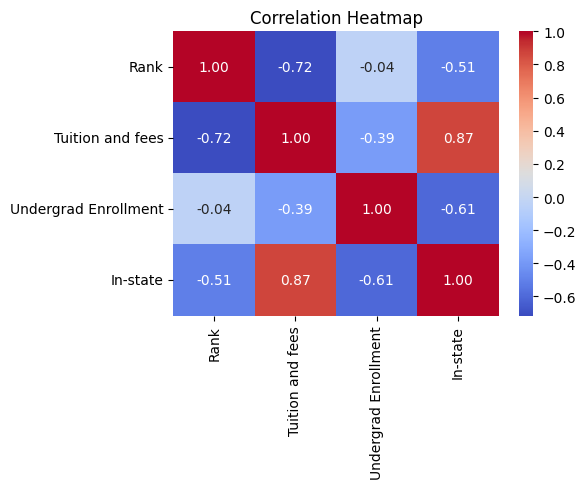

Rows used for ML: 231
Linear Regression
MAE: 28.77
R^2: 0.645
Random Forest Regressor
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
MAE: 29.61
R^2: 0.593
Random Forest Classifier
Accuracy: 0.7446808510638298
              precision    recall  f1-score   support

      Others       0.82      0.90      0.86        31
      Top100       0.33      0.25      0.29         8
       Top50       0.71      0.62      0.67         8

    accuracy                           0.74        47
   macro avg       0.62      0.59      0.60        47
weighted avg       0.72      0.74      0.73        47



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report

def clean_currency(series):
    return pd.to_numeric(series.astype(str).str.replace(r'[^0-9.]', '', regex=True), errors='coerce')

def clean_integer(series):
    return pd.to_numeric(series.astype(str).str.replace(r'[^0-9]', '', regex=True), errors='coerce').astype('Int64')

INPATH = "/content/universities_cleaned.csv"
CLEANED_CSV = "/content/universities_cleaned.csv"
df = pd.read_csv(INPATH)

for col in ["index", "Index", "Unnamed: 0"]:
    if col in df.columns:
        df = df.drop(columns=[col])

df.columns = [c.strip() for c in df.columns]
df['Tuition and fees'] = clean_currency(df['Tuition and fees']).astype(float)
if 'In-state' in df.columns:
    df['In-state'] = clean_currency(df['In-state']).astype(float)
else:
    df['In-state'] = np.nan
df['In-state'] = df['In-state'].fillna(df['Tuition and fees'])
df['Undergrad Enrollment'] = clean_integer(df['Undergrad Enrollment']).astype('Int64')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce').astype('Int64')
df.to_csv(CLEANED_CSV, index=False)

print(df.dtypes)
print(df.isnull().sum())
print(df.describe())

top10 = df.dropna(subset=["Rank"]).sort_values("Rank").head(10)
print(top10[["Rank","Name","Location","Tuition and fees","Undergrad Enrollment"]].to_string(index=False))

plt.figure(figsize=(8,4))
plt.hist(df['Tuition and fees'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Tuition and Fees")
plt.xlabel("Tuition ($)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df['Tuition and fees'], df['Undergrad Enrollment'], alpha=0.6)
plt.title("Tuition vs Undergraduate Enrollment")
plt.xlabel("Tuition ($)")
plt.ylabel("Undergraduate Enrollment")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
names = top10['Name'].astype(str).tolist()
tuition_vals = top10['Tuition and fees'].tolist()
plt.bar(names, tuition_vals, color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Universities - Tuition Fees")
plt.ylabel("Tuition ($)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(y=df['Tuition and fees'])
plt.title("Boxplot of Tuition Fees")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(y=df['Undergrad Enrollment'])
plt.title("Violin Plot of Enrollment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Rank', y='Tuition and fees', data=df)
plt.title("Rank vs Tuition Fees")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(df['Undergrad Enrollment'].dropna(), bins=30, kde=True)
plt.title("Undergraduate Enrollment Distribution")
plt.tight_layout()
plt.show()

df['State'] = df['Location'].astype(str).str.split(',').str[-1].str.strip()
state_counts = df['State'].value_counts().head(10)
plt.figure(figsize=(8,4))
state_counts.plot(kind='bar', color='purple')
plt.title("Top 10 States with Most Universities")
plt.tight_layout()
plt.show()

corr_cols = ["Rank","Tuition and fees","Undergrad Enrollment","In-state"]
corr = df[corr_cols].corr()
print(corr)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

ml_df = df[['Tuition and fees', 'Undergrad Enrollment', 'In-state', 'Rank']].dropna()
print(f"Rows used for ML: {ml_df.shape[0]}")

if ml_df.shape[0] >= 20:
    X = ml_df[['Tuition and fees', 'Undergrad Enrollment', 'In-state']].astype(float)
    y = ml_df['Rank'].astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred_lin = lin_model.predict(X_test)
    print("Linear Regression")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_lin):.2f}")
    print(f"R^2: {r2_score(y_test, y_pred_lin):.3f}")

    rf = RandomForestRegressor(random_state=42)
    param_grid = {"n_estimators": [200, 500], "max_depth": [None, 10, 20], "min_samples_split": [2, 5]}
    grid = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_rf = grid.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    print("Random Forest Regressor")
    print("Best Parameters:", grid.best_params_)
    print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
    print(f"R^2: {r2_score(y_test, y_pred_rf):.3f}")

    ml_df['RankGroup'] = pd.cut(ml_df['Rank'], bins=[0,50,100,300], labels=['Top50','Top100','Others'])
    X_cls = ml_df[['Tuition and fees','Undergrad Enrollment','In-state']]
    y_cls = ml_df['RankGroup']
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(Xc_train, yc_train)
    y_pred_cls = clf.predict(Xc_test)
    print("Random Forest Classifier")
    print("Accuracy:", accuracy_score(yc_test, y_pred_cls))
    print(classification_report(yc_test, y_pred_cls))
else:
    print("Not enough rows for ML")
